Energy Disaggregation using Neural Networks
=======================================

In [50]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
from keras.regularizers import l1
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [2]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [3]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [4]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

In [261]:
def create_seq(X):
    res = []
    rem = X.shape[0] % 5
    for i in range(0,X.shape[0],5):
#         print(i)
        if  (i+5) > X.shape[0]:
            balc = X.shape[0] - i
            res.append(np.concatenate((X[i:i+balc,:],np.zeros((i+5 - X.shape[0],X.shape[1])))))
        else:
            res.append(X[i:i+5,:])
    res = np.array(res)
    return res

In [6]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

In [7]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

Data Preprocessing 
------------------------------


In [8]:
from os import walk
path = "C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/01_sm_csv/01"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [9]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

245

In [10]:
df2 = pd.read_csv("C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/01_occupancy_csv/01_winter.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

46

In [11]:
import datetime
winter = df2.index.tolist()
df_winter = {}
for key in df.keys():
    if key in winter:
        df_winter[key]=df[key]
len(df_winter)
#df_summer["20120730"]

46

In [12]:
n = 900  #chunk row size
winter_features = pd.DataFrame()
for day, data in df_winter.items():
    list_df_winter = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_winter:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
   
    winter_features = winter_features.append(data)



NameError: name 'summer_features' is not defined

In [13]:
winter_features.loc[winter_features.ptime < 25, 'ptime'] = 0
winter_features.loc[winter_features.ptime > 89, 'ptime'] = 0
winter_features = winter_features.loc[(winter_features['ptime'] >0)]
winter_features['ptime'] = winter_features['ptime'] - 24
winter_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,31.962,71.367,12.724,117.671,102.451,77.123,13.805,188.432,41.124103,73.951360,...,0.982764,0.0,0.0,0.0,0.0,70.489,5.756,1.081,70.761,1.0
25,61.260,29.305,12.830,103.697,63.140,71.952,14.078,148.094,62.019828,49.629829,...,0.998223,0.0,0.0,0.0,0.0,1.880,42.647,1.248,44.397,2.0
26,31.784,29.146,12.801,74.261,61.818,30.320,13.705,105.087,37.478154,29.718724,...,0.997046,0.0,0.0,0.0,0.0,30.034,1.174,0.904,30.826,3.0
27,31.834,29.286,12.767,74.312,85.537,732.210,711.126,1499.400,44.506607,117.657463,...,0.993711,0.0,0.0,0.0,0.0,53.703,702.924,698.359,1425.088,4.0
28,60.703,62.578,73.014,198.783,62.417,72.426,75.204,208.476,61.504024,69.406020,...,0.518571,0.0,0.0,0.0,0.0,1.714,9.848,2.190,9.693,5.0
29,31.514,67.193,15.231,115.266,61.210,72.769,190.010,291.888,33.517404,69.431001,...,0.990901,0.0,0.0,0.0,0.0,29.696,5.576,174.779,176.622,6.0
30,31.441,120.284,14.628,167.473,232.777,1432.170,71.235,1510.260,70.363117,405.803691,...,0.988963,0.0,0.0,0.0,0.0,201.336,1311.886,56.607,1342.787,7.0
31,31.628,272.136,14.638,319.613,62.321,1492.030,71.154,1569.290,60.562291,367.408303,...,0.978802,0.0,0.0,0.0,0.0,30.693,1219.894,56.516,1249.677,8.0
32,31.615,270.531,14.485,318.229,32.680,1592.100,15.494,1638.900,32.123178,435.213368,...,0.984372,0.0,0.0,0.0,0.0,1.065,1321.569,1.009,1320.671,9.0
33,31.702,186.246,14.667,263.580,87.886,304.316,15.623,405.440,49.470382,265.839304,...,0.997615,0.0,0.0,0.0,0.0,56.184,118.070,0.956,141.860,10.0


In [14]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_winter = []
    list_oc_winter = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_winter:
        occ_winter.append(np.bincount(chunk).argmax())
    occ_winter = occ_winter[24:89]
    cuml_list.extend(occ_winter)
occ_winter_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
print(occ_winter_data) 

      occupancy
0             1
1             1
2             1
3             1
4             1
5             1
6             1
7             1
8             1
9             1
10            1
11            1
12            1
13            1
14            1
15            0
16            0
17            0
18            0
19            0
20            0
21            0
22            0
23            0
24            0
25            0
26            0
27            0
28            0
29            0
...         ...
2960          1
2961          1
2962          1
2963          1
2964          1
2965          1
2966          1
2967          1
2968          1
2969          1
2970          1
2971          1
2972          1
2973          1
2974          1
2975          1
2976          1
2977          1
2978          1
2979          1
2980          1
2981          1
2982          1
2983          1
2984          1
2985          1
2986          1
2987          1
2988          1
2989          1

[2990 r

In [15]:
winter_features[np.isnan(winter_features)] = 0

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

In [83]:
X = np.array(winter_features)
X.shape

(2990, 33)

In [84]:
y = np.array(occ_winter_data)
y.shape

(2990, 1)

In [85]:
X = normalize_data(X)
X_train =X[0:2500,:]
y_train = y[0:2500,:]

X_test = X[2500:2990,:]
y_test = y[2500:2990,:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test.shape


(490, 1)

In [86]:
X_train.shape

(2500, 33, 1)

In [87]:
X_test.shape

(490, 33, 1)

In [88]:
y_train.shape

(2500, 1)

Model Specification
-------------------------------
The following function is used to create the model.

In [75]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(16, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())    
    model.add(Dropout(0.25))
    
#     model.add(Bidirectional(LSTM(256, return_sequences=True,
#                                   stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
    
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
    
#     model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
    model.add(Flatten())
   
    model.add(Dense(128, activation='relu',kernel_initializer="he_uniform"))
    model.add(Dropout(0.25))
    
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.add(Dropout(0.25))
    
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics =['accuracy'])
    return model

In [89]:
def init_model1(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [90]:
model = init_model1(X_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_41 (Batc (None, 33, 256)           1024      
_________________________________________________________________
dropout_61 (Dropout)         (None, 33, 256)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_42 (Batc (None, 33, 128)           512       
_________________________________________________________________
dropout_62 (Dropout)         (None, 33, 128)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 33, 64)            32832     
__________

Train on 2500 samples, validate on 490 samples
Epoch 1/140
 - 12s - loss: 0.6133 - acc: 0.7552 - val_loss: 0.3910 - val_acc: 0.8653
Epoch 2/140
 - 4s - loss: 0.4826 - acc: 0.8220 - val_loss: 0.3134 - val_acc: 0.8755
Epoch 3/140
 - 4s - loss: 0.4223 - acc: 0.8416 - val_loss: 0.3241 - val_acc: 0.8714
Epoch 4/140
 - 4s - loss: 0.3913 - acc: 0.8468 - val_loss: 0.2934 - val_acc: 0.8633
Epoch 5/140
 - 4s - loss: 0.3769 - acc: 0.8580 - val_loss: 0.2845 - val_acc: 0.8694
Epoch 6/140
 - 4s - loss: 0.3618 - acc: 0.8588 - val_loss: 0.2781 - val_acc: 0.8694
Epoch 7/140
 - 4s - loss: 0.3554 - acc: 0.8580 - val_loss: 0.3313 - val_acc: 0.8347
Epoch 8/140
 - 4s - loss: 0.3480 - acc: 0.8492 - val_loss: 0.2522 - val_acc: 0.8776
Epoch 9/140
 - 4s - loss: 0.3365 - acc: 0.8600 - val_loss: 0.3029 - val_acc: 0.8653
Epoch 10/140
 - 4s - loss: 0.3252 - acc: 0.8620 - val_loss: 0.2839 - val_acc: 0.8612
Epoch 11/140
 - 4s - loss: 0.3260 - acc: 0.8660 - val_loss: 0.2699 - val_acc: 0.8755
Epoch 12/140
 - 4s - loss:

Epoch 97/140
 - 4s - loss: 0.2000 - acc: 0.9076 - val_loss: 0.2519 - val_acc: 0.8857
Epoch 98/140
 - 3s - loss: 0.1927 - acc: 0.9100 - val_loss: 0.2326 - val_acc: 0.8857
Epoch 99/140
 - 4s - loss: 0.1963 - acc: 0.9156 - val_loss: 0.2267 - val_acc: 0.8939
Epoch 100/140
 - 4s - loss: 0.2090 - acc: 0.9092 - val_loss: 0.2901 - val_acc: 0.8939
Epoch 101/140
 - 4s - loss: 0.2086 - acc: 0.9056 - val_loss: 0.2613 - val_acc: 0.8878
Epoch 102/140
 - 4s - loss: 0.1866 - acc: 0.9208 - val_loss: 0.2296 - val_acc: 0.8939
Epoch 103/140
 - 4s - loss: 0.1991 - acc: 0.9108 - val_loss: 0.2500 - val_acc: 0.8898
Epoch 104/140
 - 4s - loss: 0.1808 - acc: 0.9220 - val_loss: 0.2566 - val_acc: 0.8837
Epoch 105/140
 - 4s - loss: 0.1841 - acc: 0.9184 - val_loss: 0.2663 - val_acc: 0.8735
Epoch 106/140
 - 4s - loss: 0.1911 - acc: 0.9112 - val_loss: 0.2650 - val_acc: 0.8939
Epoch 107/140
 - 4s - loss: 0.1971 - acc: 0.9112 - val_loss: 0.3043 - val_acc: 0.8755
Epoch 108/140
 - 4s - loss: 0.1994 - acc: 0.9064 - val_lo

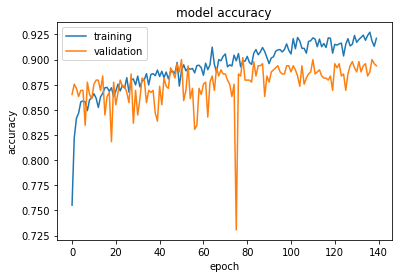

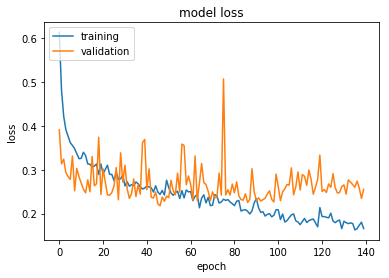

In [91]:
history = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss = model.fit(X_train, y_train, epochs=140, batch_size=64,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=64)
# print(score)
# plot_losses(history.losses)

print(score)
plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test)

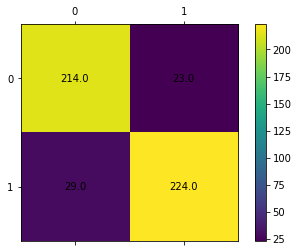

In [92]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [ ]:
import shap

# select a set of background examples to take an expectation over
background = X_train
# [np.random.choice(x_train.shape[0], 100, replace=False)]


In [49]:
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

KeyboardInterrupt: 

In [ ]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

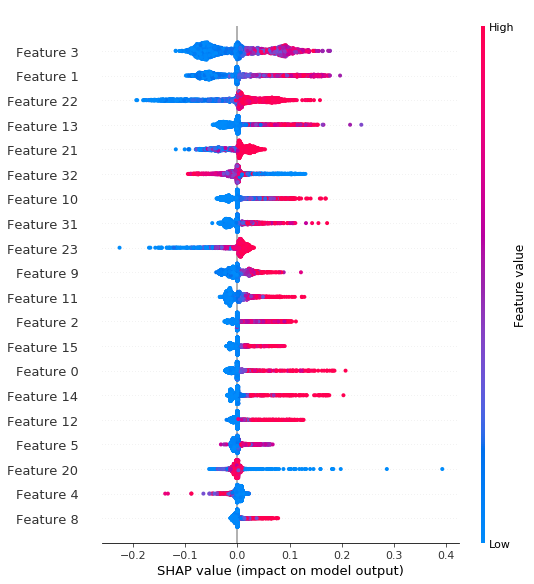

In [31]:
shap.summary_plot(shap_values[0], X_postprocess)

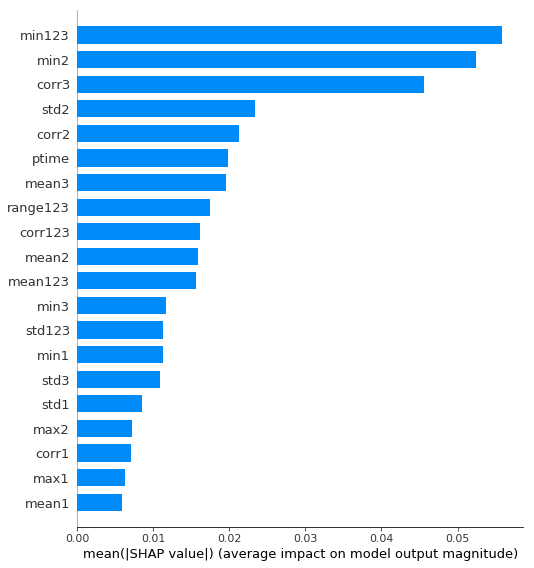

In [33]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar",feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

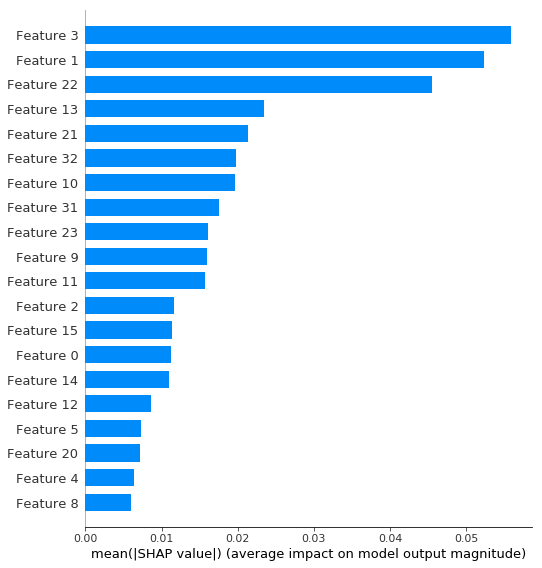

In [34]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely Values
-------------

In [313]:
# new_summer_features= X[:,0:14]
new_summer_features = np.concatenate((X[:,1], X[:,3], X[5],X),axis=1)
new_summer_features.shape


(2535, 31)

In [320]:
X_train1 =new_summer_features[0:2400,:]
X_test1 = new_summer_features[2400:2535,:]

X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1)
X_test1.shape[1]

31

In [324]:
model = init_model(X_train1.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_53 (Conv1D)           (None, 31, 16)            80        
_________________________________________________________________
dropout_200 (Dropout)        (None, 31, 16)            0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 496)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               63616     
_________________________________________________________________
dropout_201 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 129       
_________________________________________________________________
dropout_202 (Dropout)        (None, 1)                 0         
Total para

Train on 2400 samples, validate on 135 samples
Epoch 1/500
 - 0s - loss: 3.1096 - acc: 0.7367 - val_loss: 0.1761 - val_acc: 0.9111
Epoch 2/500
 - 0s - loss: 3.1959 - acc: 0.7288 - val_loss: 0.1814 - val_acc: 0.9037
Epoch 3/500
 - 0s - loss: 3.1209 - acc: 0.7258 - val_loss: 0.1909 - val_acc: 0.8963
Epoch 4/500
 - 0s - loss: 3.3458 - acc: 0.7200 - val_loss: 0.1903 - val_acc: 0.8815
Epoch 5/500
 - 0s - loss: 3.0124 - acc: 0.7288 - val_loss: 0.2098 - val_acc: 0.8889
Epoch 6/500
 - 0s - loss: 3.1945 - acc: 0.7350 - val_loss: 0.1947 - val_acc: 0.8889
Epoch 7/500
 - 0s - loss: 3.2934 - acc: 0.7317 - val_loss: 0.1753 - val_acc: 0.8889
Epoch 8/500
 - 0s - loss: 3.2919 - acc: 0.7258 - val_loss: 0.1800 - val_acc: 0.8815
Epoch 9/500
 - 0s - loss: 3.2422 - acc: 0.7242 - val_loss: 0.1965 - val_acc: 0.8815
Epoch 10/500
 - 0s - loss: 3.3237 - acc: 0.7275 - val_loss: 0.1577 - val_acc: 0.9259
Epoch 11/500
 - 0s - loss: 3.2153 - acc: 0.7283 - val_loss: 0.1732 - val_acc: 0.9185
Epoch 12/500
 - 0s - loss: 

Epoch 97/500
 - 0s - loss: 3.1875 - acc: 0.7271 - val_loss: 0.1967 - val_acc: 0.8889
Epoch 98/500
 - 0s - loss: 3.1937 - acc: 0.7288 - val_loss: 0.1851 - val_acc: 0.9037
Epoch 99/500
 - 0s - loss: 3.3658 - acc: 0.7192 - val_loss: 0.1682 - val_acc: 0.9185
Epoch 100/500
 - 0s - loss: 3.3737 - acc: 0.7192 - val_loss: 0.1748 - val_acc: 0.9185
Epoch 101/500
 - 0s - loss: 3.2970 - acc: 0.7279 - val_loss: 0.1717 - val_acc: 0.9111
Epoch 102/500
 - 0s - loss: 3.1011 - acc: 0.7313 - val_loss: 0.1710 - val_acc: 0.9111
Epoch 103/500
 - 0s - loss: 3.3344 - acc: 0.7204 - val_loss: 0.1667 - val_acc: 0.9259
Epoch 104/500
 - 0s - loss: 3.3250 - acc: 0.7300 - val_loss: 0.1661 - val_acc: 0.9259
Epoch 105/500
 - 0s - loss: 3.3601 - acc: 0.7208 - val_loss: 0.2351 - val_acc: 0.8519
Epoch 106/500
 - 0s - loss: 2.9926 - acc: 0.7358 - val_loss: 0.1963 - val_acc: 0.8741
Epoch 107/500
 - 0s - loss: 3.0676 - acc: 0.7362 - val_loss: 0.2065 - val_acc: 0.8593
Epoch 108/500
 - 0s - loss: 3.2601 - acc: 0.7258 - val_lo

Epoch 193/500
 - 0s - loss: 3.1610 - acc: 0.7358 - val_loss: 0.2046 - val_acc: 0.9111
Epoch 194/500
 - 0s - loss: 3.2558 - acc: 0.7308 - val_loss: 0.1804 - val_acc: 0.9333
Epoch 195/500
 - 0s - loss: 3.2515 - acc: 0.7288 - val_loss: 0.2045 - val_acc: 0.9111
Epoch 196/500
 - 0s - loss: 3.0520 - acc: 0.7346 - val_loss: 0.1620 - val_acc: 0.9333
Epoch 197/500
 - 0s - loss: 3.2531 - acc: 0.7271 - val_loss: 0.1857 - val_acc: 0.9259
Epoch 198/500
 - 0s - loss: 3.1490 - acc: 0.7375 - val_loss: 0.1938 - val_acc: 0.8963
Epoch 199/500
 - 0s - loss: 3.0828 - acc: 0.7463 - val_loss: 0.1820 - val_acc: 0.9259
Epoch 200/500
 - 0s - loss: 3.2927 - acc: 0.7275 - val_loss: 0.1919 - val_acc: 0.8963
Epoch 201/500
 - 0s - loss: 3.3427 - acc: 0.7325 - val_loss: 0.1687 - val_acc: 0.9185
Epoch 202/500
 - 0s - loss: 3.1346 - acc: 0.7421 - val_loss: 0.1658 - val_acc: 0.9259
Epoch 203/500
 - 0s - loss: 3.1368 - acc: 0.7342 - val_loss: 0.1743 - val_acc: 0.9259
Epoch 204/500
 - 0s - loss: 3.1633 - acc: 0.7362 - val

Epoch 289/500
 - 0s - loss: 3.1971 - acc: 0.7342 - val_loss: 0.1863 - val_acc: 0.9185
Epoch 290/500
 - 0s - loss: 3.3809 - acc: 0.7225 - val_loss: 0.2007 - val_acc: 0.8963
Epoch 291/500
 - 0s - loss: 3.0119 - acc: 0.7458 - val_loss: 0.1992 - val_acc: 0.8815
Epoch 292/500
 - 0s - loss: 2.9784 - acc: 0.7492 - val_loss: 0.1650 - val_acc: 0.9185
Epoch 293/500
 - 0s - loss: 3.2372 - acc: 0.7279 - val_loss: 0.1748 - val_acc: 0.9185
Epoch 294/500
 - 0s - loss: 3.2773 - acc: 0.7313 - val_loss: 0.1874 - val_acc: 0.8963
Epoch 295/500
 - 0s - loss: 3.3274 - acc: 0.7321 - val_loss: 0.1851 - val_acc: 0.9037
Epoch 296/500
 - 0s - loss: 3.3655 - acc: 0.7279 - val_loss: 0.2147 - val_acc: 0.8889
Epoch 297/500
 - 0s - loss: 3.2799 - acc: 0.7350 - val_loss: 0.1885 - val_acc: 0.9111
Epoch 298/500
 - 0s - loss: 3.1101 - acc: 0.7417 - val_loss: 0.1853 - val_acc: 0.9111
Epoch 299/500
 - 0s - loss: 3.1911 - acc: 0.7438 - val_loss: 0.1727 - val_acc: 0.9111
Epoch 300/500
 - 0s - loss: 3.3523 - acc: 0.7254 - val

Epoch 385/500
 - 0s - loss: 3.5832 - acc: 0.7058 - val_loss: 0.1672 - val_acc: 0.9259
Epoch 386/500
 - 0s - loss: 3.3470 - acc: 0.7262 - val_loss: 0.1550 - val_acc: 0.9259
Epoch 387/500
 - 0s - loss: 3.1803 - acc: 0.7250 - val_loss: 0.2043 - val_acc: 0.9037
Epoch 388/500
 - 0s - loss: 3.1902 - acc: 0.7338 - val_loss: 0.1679 - val_acc: 0.9407
Epoch 389/500
 - 0s - loss: 3.0651 - acc: 0.7375 - val_loss: 0.1693 - val_acc: 0.9259
Epoch 390/500
 - 0s - loss: 3.3049 - acc: 0.7342 - val_loss: 0.1712 - val_acc: 0.9259
Epoch 391/500
 - 0s - loss: 3.2643 - acc: 0.7304 - val_loss: 0.1796 - val_acc: 0.9037
Epoch 392/500
 - 0s - loss: 2.9948 - acc: 0.7467 - val_loss: 0.1746 - val_acc: 0.9185
Epoch 393/500
 - 0s - loss: 3.1192 - acc: 0.7458 - val_loss: 0.1710 - val_acc: 0.9259
Epoch 394/500
 - 0s - loss: 3.3634 - acc: 0.7225 - val_loss: 0.1769 - val_acc: 0.9185
Epoch 395/500
 - 0s - loss: 2.9235 - acc: 0.7525 - val_loss: 0.1785 - val_acc: 0.9185
Epoch 396/500
 - 0s - loss: 3.2029 - acc: 0.7358 - val

Epoch 481/500
 - 0s - loss: 3.3222 - acc: 0.7362 - val_loss: 0.1714 - val_acc: 0.9111
Epoch 482/500
 - 0s - loss: 3.1821 - acc: 0.7396 - val_loss: 0.1721 - val_acc: 0.9333
Epoch 483/500
 - 0s - loss: 3.4285 - acc: 0.7250 - val_loss: 0.1979 - val_acc: 0.8889
Epoch 484/500
 - 0s - loss: 3.3433 - acc: 0.7283 - val_loss: 0.1881 - val_acc: 0.9037
Epoch 485/500
 - 0s - loss: 3.2213 - acc: 0.7317 - val_loss: 0.1893 - val_acc: 0.9111
Epoch 486/500
 - 0s - loss: 3.2727 - acc: 0.7262 - val_loss: 0.1751 - val_acc: 0.9407
Epoch 487/500
 - 0s - loss: 3.1902 - acc: 0.7367 - val_loss: 0.1864 - val_acc: 0.8963
Epoch 488/500
 - 0s - loss: 3.4661 - acc: 0.7200 - val_loss: 0.1902 - val_acc: 0.8889
Epoch 489/500
 - 0s - loss: 3.2225 - acc: 0.7404 - val_loss: 0.1685 - val_acc: 0.9111
Epoch 490/500
 - 0s - loss: 2.9806 - acc: 0.7433 - val_loss: 0.1867 - val_acc: 0.9185
Epoch 491/500
 - 0s - loss: 3.3784 - acc: 0.7275 - val_loss: 0.1630 - val_acc: 0.9259
Epoch 492/500
 - 0s - loss: 3.2736 - acc: 0.7279 - val

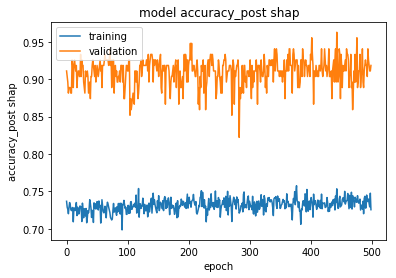

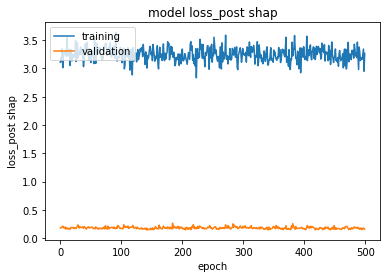

In [327]:
history1 = LossHistory()
hiss1 = model.fit(X_train1, y_train, epochs=500, batch_size=32,
                callbacks=[history1],
                validation_data=(X_test1,y_test), verbose=2)
score1 = model.evaluate(X_test1, y_test, batch_size=64)
print(score1)
plt.plot(hiss1.history['acc'])
plt.plot(hiss1.history['val_acc'])
plt.title('model accuracy_post shap')
plt.ylabel('accuracy_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss1.history['loss'])
plt.plot(hiss1.history['val_loss'])
plt.title('model loss_post shap')
plt.ylabel('loss_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test1)